# HumBug data processing

### Note, this notebook contains two sets of functions for processing data. One is concerned with labels from the Culex labelled dataset. The other, with suffix _cdc, is currently in place to experiment with the algorithm in unlabelled datasets

The functions associated with the CDC dataset require some building blocks from the culex data functions.

A minimal working example (for the hand-labelled Culex set) consists of running all the cells sequentially in Section 1, and is highly recommended for validating operation of every code block.

`CNNBirdClef.ipynb` is then used for visualising network filters and other features in more depth

In [1]:
#import audacity
import numpy as np
import sys 
import os, os.path
from scipy.io.wavfile import read, write
from scipy import signal
from scipy import nanmean


import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from collections import Counter

import random

# Keras-related imports
from keras.models import Sequential
from keras.regularizers import WeightRegularizer
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model


import itertools
from scipy.signal import find_peaks_cwt

sys.path.append('lib')
#sys.path.append('lib/kiswav')
import proc_data_lib as detector_lib

# Optional: LaTeX cm font (slow)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

Using Theano backend.


In [2]:
# Culex data (labelled with data_dz_corrob etc.)
data_path = 'data/Culex Quinquefasciatus/audio/'
label_path = 'data/Culex Quinquefasciatus/labels/'

signal_list, label_list, label_names, fs = detector_lib.import_file(data_path, label_path)





Processed 57 files.
Processed 7 labels.


The gold standard label is given by `select_label = 5`.


If implementing a sort of majority voting (`maj_vote = True`), specify the `count_method` with a string. Options are:

`'most_positive'`: If any label contains a positive, assign a label of +1

`'two_or_more'`: if two or more labels agree, assign that label

`'agreement'`: only assign samples where each label agrees.

Any other string will result in a ValueError.

In [3]:
t = detector_lib.proc_label(signal_list = signal_list, label_list = label_list, label_names = label_names)

['data_corrob_ac.txt', 'data_corrob_all_0or1.txt', 'data_corrob_all_0to1.txt', 'data_corrob_all_1to4.txt', 'data_corrob_cm.txt', 'data_corrob_dz.txt', 'data_corrob_ms.txt']
Using label data_corrob_dz.txt


Training feature set:

x dimensions (6209, 1, 256, 10)
y dimensions (6209, 2)

Testing feature set:

x dimensions (3274, 1, 256, 10)
y dimensions (3274, 2)


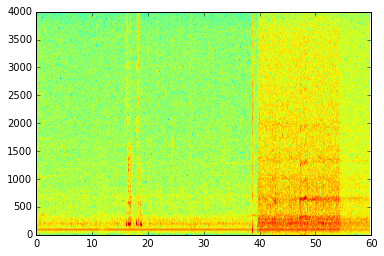

In [4]:
# Specify whether data to be used in convnet or MLP
conv = True

# Parameters for feature extraction
spec_window = 10  # Image width in number of spectrogram samples 
n_fft = 512  # n_fft is twice the number of frequency bins used
n_overlap = 256 # Number of overlapping samples

# Split data into training and testing
test_idx = np.array([1,5,19,11,17,18,19,24,28,30,32,35,36,37,38,42,45,49,56,57]) - 1 # Corrected for index convention

train_x, train_t, test_x, test_t = detector_lib.data_split(signal_list, t, test_idx) 

# Extract data features
print 'Training feature set:'
x_train_spec, y_train_spec, input_shape, spec_freq = detector_lib.proc_data_humbug(train_x, train_t, fs, n_fft/2,spec_window,
                                                                        nfft = n_fft, overlap = n_overlap)
print '\nTesting feature set:'
x_test_spec, y_test_spec, input_shape, spec_freq = detector_lib.proc_data_humbug(test_x, test_t, fs, n_fft/2,spec_window,
                                                          nfft = n_fft, overlap = n_overlap)

# Reshape data for MLP
if not conv:
    x_train_spec = x_train_spec.reshape(x_train_spec.shape[0], x_train_spec.shape[-2]*x_train_spec.shape[-1])
    x_test_spec = x_test_spec.reshape(x_test_spec.shape[0], x_test_spec.shape[-2]*x_test_spec.shape[-1])

## Neural network execution

### Data prep

Left in this code block to show the syntax for combining training data from different domains. Will correctly concatenate as long as the parameters used in proc_data_humbug and proc_data_humbug_cdc are equivalent.

In [5]:
x_train = x_train_spec
y_train = y_train_spec
x_test = x_test_spec
y_test = y_test_spec

### Parameterise network as necessary
For details on parameters, see documentation at:
https://keras.io/getting-started/sequential-model-guide/

and a further example on:
https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [6]:
## NN parameters

# number of convolutional filters
nb_conv_filters = 32
num_hidden = 236
n_dense = 128

arbitrary = 1
# size of pooling area for max pooling
pool_size = (2,2)

# convolution kernel size 
kernel_size_1 = (3,3)
kernel_size_2 = (3,3)
# number of classes
nb_classes = 2

# Initialise model

model = Sequential()

if conv:
    input_shape = (1, x_train.shape[2], x_train.shape[-1])

    model.add(Convolution2D(nb_conv_filters, kernel_size_1[0], kernel_size_1[1],
                           border_mode = 'valid',
                           input_shape = input_shape))
    convout1 = Activation('relu')
    model.add(convout1)
    model.add(Flatten())
    model.add(Activation('relu'))

else:    
    model.add(Dense(num_hidden, input_dim=np.shape(x_train)[1]))
    model.add(Activation('relu'))
    
model.add(Dense(n_dense))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 236)           604396      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 236)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 128)           30336       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 128)           0           dense_2[0][0]                    
___________________________________________________________________________________________

In [8]:
# If not saving weights, the model object (model) and the training history (out_arg) are returned. 
# Saving weights returns the model object (model) and the weights after each epoch of training (out_arg)

model, out_arg = detector_lib.train_nn(model, x_train, y_train, x_test, y_test, conv = conv, save_weights=False)

Using MLP:
Training data shape: (6209, 2560)
Epoch 1/20
0s - loss: 3.4914 - acc: 0.7499
Epoch 2/20
0s - loss: 2.6779 - acc: 0.8082
Epoch 3/20
0s - loss: 2.1020 - acc: 0.8472
Epoch 4/20
0s - loss: 1.8988 - acc: 0.8641
Epoch 5/20
0s - loss: 1.6952 - acc: 0.8750
Epoch 6/20
0s - loss: 1.7003 - acc: 0.8778
Epoch 7/20
0s - loss: 1.6365 - acc: 0.8792
Epoch 8/20
0s - loss: 1.6763 - acc: 0.8757
Epoch 9/20
0s - loss: 1.6569 - acc: 0.8771
Epoch 10/20
0s - loss: 1.6002 - acc: 0.8836
Epoch 11/20
0s - loss: 1.4511 - acc: 0.8948
Epoch 12/20
0s - loss: 1.4483 - acc: 0.8937
Epoch 13/20
0s - loss: 1.4587 - acc: 0.8942
Epoch 14/20
0s - loss: 1.3489 - acc: 0.9001
Epoch 15/20
0s - loss: 1.4648 - acc: 0.8919
Epoch 16/20
0s - loss: 1.3646 - acc: 0.8990
Epoch 17/20
0s - loss: 1.4123 - acc: 0.8985
Epoch 18/20
0s - loss: 1.3859 - acc: 0.9006
Epoch 19/20
0s - loss: 1.4867 - acc: 0.8924
Epoch 20/20
0s - loss: 1.4610 - acc: 0.8945


### Functions necessary for predictions end here. The remaining functions and scripts in Section 1 are for performance analysis and visualisation

True positive rate 0.66846361186 True negative rate 1.0
F1 score 0.783157894737


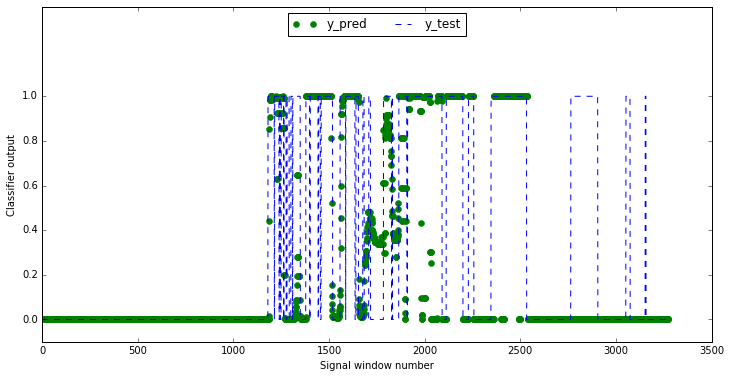

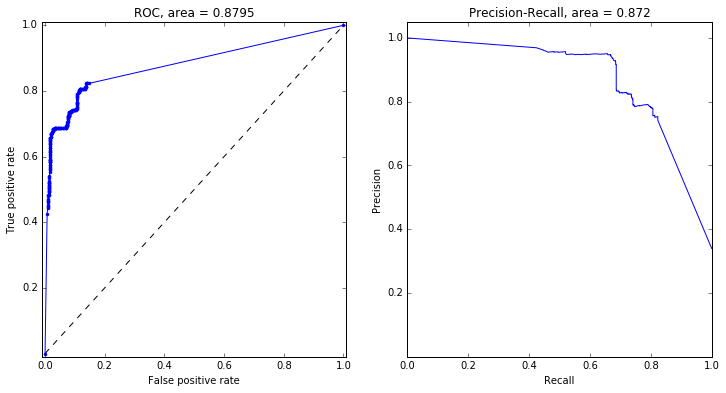

In [9]:
# Option to use median filtering with filter length set by kernel_size.
# Option to visualise a specific part of the signal output with x_lim = [x_min, x_max]

# Could add condition to test for y_test, and only generate predictions without the test labels if we do not have any
predictions, perf_metrics = detector_lib.plot_output(x_test, y_test, model, median_filtering=True, kernel_size=31, x_lim=None)


 ### Analyse statistics of evaluations


In [ ]:
detector_lib.anal_test(predictions, x_test, conv = conv)

In [10]:
### Representative of mozz or no_mozz from raw data labels

mozz = np.where(y_train[:,0])
no_mozz = np.where(y_train[:,1])

mozz_samples = x_train[mozz].reshape(x_train[mozz].shape[0] * x_train[mozz].shape[-1], x_train[mozz].shape[2])
no_mozz_samples = x_train[no_mozz].reshape(x_train[no_mozz].shape[0] * x_train[no_mozz].shape[-1], x_train[no_mozz].shape[2])

binned_fft = np.mean(mozz_samples, axis = 0)
binned_fft_negative = np.mean(no_mozz_samples, axis = 0)

IndexError: tuple index out of range

 #### Wavelet

In [10]:
############### Chooose whether or not to save figure#################
save_fig = False
suffix = ''


#### Statistics of samples that trigger a high response
frac_data = 0.1
sort_index = np.argsort(predictions[:,0])
sort_index_low = np.argsort(predictions[:,1])


print 'Number of test samples', len(x_test)
n_response_samples = int(len(x_test) * frac_data)
print 'Number of high response samples,', n_response_samples, 'percentage of test data', frac_data * 100, '%'

high_response_samples = x_test[sort_index[(len(sort_index) - n_response_samples):]]
low_response_samples = x_test[sort_index_low[(len(sort_index_low) - n_response_samples):]]

print 'Number of high response samples', n_response_samples, 'data shape', np.shape(high_response_samples)
#plot amplitude vs frequency for 1 dimensional signal bin?
#plt.plot(spec_freq or wav_freq, )
if conv:
    high_response_samples = high_response_samples.reshape([high_response_samples.shape[0]*high_response_samples.shape[-1],
                                                         high_response_samples.shape[-2]])
    low_response_samples = low_response_samples.reshape([low_response_samples.shape[0]*low_response_samples.shape[-1],
                                                         low_response_samples.shape[-2]])

print 'reshaped', np.shape(high_response_samples)
high_response_samples = np.fliplr(high_response_samples)
low_response_samples = np.fliplr(low_response_samples)


# With python's cwt peak finder
function_points = np.mean(high_response_samples[:50], axis = 0) # pick top 50 detections
ind = find_peaks_cwt(function_points, np.arange(1,3),min_length=1.5) # filter out fewer labels

function_points_low = np.mean(low_response_samples[:50], axis = 0) # pick top 50 detections
ind_low = find_peaks_cwt(function_points_low, np.arange(1,3),min_length=1.5) # filter out fewer labels

# High sample box plot
d = np.zeros(len(wav_freq)).astype(str)
d[ind] = np.round(wav_freq[ind]).astype(int)
d[np.where(d == '0.0')] = ''
print 'y_ticklabels', d[::-1]

# plt.title('Spectrum of strongest response')
# plt.plot(wav_freq, high_response_samples[0])
# plt.xlabel('Wavelet centre frequency')
# plt.ylabel('Amplitude of wavelet coefficient')
# plt.show()

box_labels = wav_freq.astype(int)[::-1]



# f = plt.figure(figsize = (5,5))
# ax = plt.subplot()
# ax.boxplot(high_response_samples, vert = False, labels=box_labels, manage_xticks=True, showbox=True, showfliers=False,  showmeans=True,  showcaps=True)
# ax.set_yticklabels(d[::-1])#, fontsize = 12)
# ax.set_title('Strongest positive responses')
# plt.ylabel('Wavelet centre frequency')
# plt.xlabel('Amplitude of wavelet coefficient')
# plt.grid()
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/WavPositive' + suffix + '.pdf')
# plt.show()


### Low sample box plot
d = np.zeros(len(wav_freq)).astype(str)
d[ind_low] = np.round(wav_freq[ind_low]).astype(int)
d[np.where(d == '0.0')] = ''
print 'y_ticklabels', d[::-1]

box_labels = wav_freq.astype(int)[::-1]



f = plt.figure(figsize = (5,5))
ax = plt.subplot()
ax.boxplot(low_response_samples, vert = False, labels=box_labels, manage_xticks=True, showbox=True, showfliers=False,  showmeans=True,  showcaps=True)
ax.set_yticklabels(d[::-1])#, fontsize = 12)
ax.set_title('Strongest negative responses')
plt.ylabel('Wavelet centre frequency')
plt.xlabel('Amplitude of wavelet coefficient')
plt.grid()
# if save_fig:
#     plt.savefig('../../../TexFiles/Papers/ECML/Images/WavNegative' + suffix + '.pdf')
# plt.show()



low_response_samples = np.fliplr(low_response_samples)


label_size = 12
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

plt.figure(figsize = (7,4))
box_means = np.mean(high_response_samples, axis = 0)
box_means_low = np.mean(low_response_samples, axis = 0)
plt.plot(wav_freq, (box_means-np.mean(box_means))/np.std(box_means),'g', label = '$\\mathbf{x}_{1,\\textrm{test}}(f)$' )
plt.plot(wav_freq, (box_means_low-np.mean(box_means_low))/np.std(box_means_low),'r', 
         label = '$\\mathbf{x}_{0,\\textrm{test}}(f)$' )
plt.plot(wav_freq,(binned_fft -np.mean(binned_fft))/np.std(binned_fft), 'blue', label = '$\\mathbf{x}_{1,\\textrm{train}}(f)$')
plt.plot(wav_freq,(binned_fft_negative -np.mean(binned_fft_negative))/np.std(binned_fft_negative),
         'k', label = '$\\mathbf{x}_{0,\\textrm{train}}(f)$')

# plt.plot(wav_freq, (box_means-0),'b', label = 'top score means' )
# plt.plot(wav_freq, (box_means_low-0),'.r', label = 'bottom score means' )
# plt.plot(wav_freq,(binned_fft -0), 'g', label = 'mosquito mean')
# plt.plot(wav_freq,(binned_fft_negative -0), '.k', label = 'noise mean')

plt.legend(fontsize=12)
plt.grid()
plt.xlabel('Wavelet centre frequency (Hz)', fontsize = 12)
plt.ylabel('Standardised wavelet coefficient amplitude', fontsize = 12)
plt.tight_layout()
if save_fig:
    print 'saved fella m8'
    plt.savefig('../../../TexFiles/Papers/ECML/Images/MeanMosquito' + suffix + '.pdf')
plt.show()


NameError: name 'predictions' is not defined

#### CNN and MLP

In [ ]:
function_points = np.mean(high_response_samples[:50], axis = 0)
indexes = peak.indexes(function_points)
ind = find_peaks_cwt(function_points, np.arange(1,4),min_length=2)
print indexes
print function_points[indexes]
plt.plot(function_points)
plt.plot(indexes, function_points[indexes],'gx', markersize = 15)
plt.plot(ind, function_points[ind],'ro', markersize = 15)



# plt.show()

# function_points = np.sin(np.linspace(0,10,100))


# indexes = peak.indexes(function_points, thres= 0)
# ind = find_peaks_cwt(function_points, np.arange(1,4))
# plt.plot(function_points)
# plt.plot(indexes, function_points[indexes],'gx', markersize = 15)
# plt.plot(ind, function_points[ind],'bx', markersize = 15)
# plt.ylim([-1.5, 1.5])

# Section 3: Wavelet implementation

# TURN INTO FUNCTION FOR WAVELET RESHAPING AT A FIXED SCALE

In [ ]:
# Experimental code for reshaping wavelet into larger spectrogram windows, re-sampling labels, and preserving information 
# without need to re-run the wavelet transform


x_train_raw = np.squeeze(x_train_wav)
x_test_raw = np.squeeze(x_test_wav)


training_sample_length = 10
print 'squeezycakes', x_train_raw.shape
n_feats = np.shape(x_train_raw)[1]

cut_idx = (x_train_raw.shape[0]/training_sample_length) * training_sample_length
print 'cut_idx', cut_idx
x_train_cut = x_train_raw[:cut_idx,:]
y_train_cut = y_train_wav[:cut_idx]
cut_idx = (x_test_raw.shape[0]/training_sample_length) * training_sample_length
print 'cut_idx', cut_idx
x_test_cut = x_test_raw[:cut_idx,:]
y_test_cut = y_test_wav[:cut_idx]
x_train_caged = x_train_cut.reshape(x_train_cut.shape[0]/training_sample_length, x_train_cut.shape[1],
                                    training_sample_length)


x_test = x_test_cut.reshape(x_test_cut.shape[0]/training_sample_length, x_test_cut.shape[1],
                            training_sample_length)
print np.arange(len(x_train_caged))
print np.arange(len(y_train_cut))
y_train_pos = np.rint(np.interp(np.arange(len(x_train_caged))*10, np.arange(len(y_train_cut)), y_train_cut[:,0]))
y_train_neg = 1 - y_train_pos
print 'training samples', len(y_train_cut), len(y_test_cut)
#plt.plot(y_train_wav)
plt.figure(figsize = (20,20))
plt.plot(y_train_cut[:,0], 'gx')
print 'interpolated wavelet labels', len(y_train_pos)
plt.plot(y_train_pos, 'kx')



y_test_pos = np.rint(np.interp(np.arange(len(x_test))*10, np.arange(len(y_test_cut)), y_test_cut[:,0]))
y_test_neg = 1 - y_test_pos

y_train = np.vstack([y_train_pos,y_train_neg]).T
y_train_caged = y_train
y_test = np.vstack([y_test_pos,y_test_neg]).T


x_train = x_train_caged.reshape((np.shape(x_train_caged)[0],1,x_train_wav.shape[2],training_sample_length))
x_test = x_test.reshape((np.shape(x_test)[0],1,x_test_wav.shape[2],training_sample_length))

print x_train.shape
print x_test.shape

In [ ]:
vis_idx = 23
end_idx = 40000

y = signal_list[vis_idx][:end_idx]
# derp derp, t only goes to 600.........
x = t[vis_idx]



In [ ]:
wav_params = np.array([3., 0.1]) # mu, sigma

#scales = bw.create_scale(200.,6000,5/(2*np.pi),fs,50) # low freq, high freq, centre freq, rate, logspacing
win_size = 40 # In samples I believe? 400 samples at 8 kHz is 0.05 seconds
scales = bw.create_scale(200.,6000, 5/(2*np.pi), fs, 50)
plt.plot(scales)
plt.show()
print 'Number of wavelet scales', np.shape(scales)

wavelet = bw.bumpcwt(scales, wav_params, y, fs)
plt.plot(wavelet.frequencies)
#bw.bumpcwt(scales, wav_params, signal, fs)

In [ ]:
### http://stackoverflow.com/questions/20322079/downsample-a-1d-numpy-array
# Reference for downsampling method
maj_vote = True
count_method = 'most_positive'

fs = 8000
font_size = 13
label_size = 13
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

print 'Number of wavelet scales', np.shape(scales)
t_data = (np.arange(len(y), dtype = 'float32'))/fs


f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False, figsize = (7,5))

#plt.title('Spectrogram')
res = ax1.specgram(y, Fs = fs, NFFT = 512, noverlap = 256,interpolation='nearest')
ax1.set_ylim([wavelet.frequencies[-1], wavelet.frequencies[0]])
ax1.set_xlim([0, t_data[-1]])
ax1.set_ylabel('Frequency (Hz)', fontsize = font_size)


t_initial = np.arange(len(x))
t_final = np.arange(0, len(x),1./(label_interval*fs))

t_corrected = np.interp(t_final, t_initial, x)  
            

b = wavelet.cwtcfs

# Perform binning in time-domain to match dimensions of spectrogram
R = int(np.ceil(float(np.shape(b)[1])/len(res[2]))) # Downsampling rate R
pad_size = np.ceil(float(np.shape(b)[1])/R)*R - np.shape(b)[1]


b_padded = np.hstack([b, np.zeros([b.shape[0], int(pad_size)])*np.NaN])
print 'b padded shape',b_padded.shape
rotato = b_padded.T.reshape(-1,R,b.shape[0])
cwtcfs_reshape = nanmean(np.abs(rotato), axis=1)  # Maybe take the mean of the spectrum/abs vals here instead?
cwtcfs_reshape = cwtcfs_reshape.T
print 'cwt reshaped size', cwtcfs_reshape.shape
print 'Reshape factor', R

t_wav = np.arange(cwtcfs_reshape.shape[1],dtype = 'float32')/spec_fs

#plt.figure(figsize = (15,6))
#ax2.set_title('Mean Binned CWT')
ax2.pcolormesh(t_wav,wavelet.frequencies, 10 * np.log10(cwtcfs_reshape), rasterized = True)
ax2.set_ylabel('Frequency (Hz)', fontsize = font_size)
#plt.colorbar()
ax2.set_ylim([wavelet.frequencies[-1], wavelet.frequencies[0]])
#ax2.set_xlim([t_wav[0], t_wav[-1]])
#plt.show()

xt = res[2]
xp = np.arange(b.shape[1],dtype = 'float32')/fs

print np.shape(xt), np.shape(xp)
new_coefs = np.zeros([b.shape[0], len(res[2])])
print 'Interpolated shape', np.shape(new_coefs)
for i, coefs in enumerate(b):    
    new_coefs[i,:] = np.interp(xt,xp, np.abs(coefs))
cwtcfs_reshape = new_coefs

t_wav = np.arange(cwtcfs_reshape.shape[1],dtype = 'float32')/spec_fs


#ax3.plot((t_final * label_interval)[:end_idx], t_corrected[:end_idx], 'g')
#ax3.xlim([t_wav[0], t_wav[-1]])

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

t_array = []

ii = vis_idx  # Index for visualisation
#lines = ['r--','bs','g^','kx']

if maj_vote:
    print maj_vote
    for idx, who in enumerate([0,4,5,6]):
        t = []    

        print 'Using label', label_names[who]
        for index, item in enumerate(label_list[who]):
            t_entry = [float(i) for i in item]
            t.append(t_entry[:len(signal_list[index-1])])    # -1 Corrects for extra label present

        t = np.delete(t, (0), axis = 0)
        t_array.append(np.array(t))
        print 't shape post processing', np.shape(t.squeeze())

        print 't array shape', np.shape(t_array)


        t_initial = np.arange(0, len(t[ii]))
        t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
        t_corrected = np.interp(t_final, t_initial, t[ii])
        t_corrected = np.rint(t_corrected)

        ax3.plot((t_final/(1./label_interval))[:end_idx] , t_corrected[:end_idx]+ 0.01 * idx)

    print 'number of specgram time windows', len(im[2])
    print 'number of time labels', len(t_corrected)
    print 'last spectrogram time', im[2][-1]
    print 'Length of t_initial', len(t[ii])
    print 'Length of t_final', len(t_corrected)

    t = np.zeros([57,600])

    t_array = np.array(t_array)
    for j in range(np.shape(t_array)[1]):
        for i in range(np.shape(t_array)[2]):
            count = Counter(t_array[:,j,i])
            if count_method == 'two_or_more':
                if count[0] == count[1]:  # Tiebreak
                    t[j,i] = 1.  # As a result, 2 or more 1s are classified as 1
                else:
                    t[j,i] = count.most_common()[0][0]
            elif count_method == 'agreement':
                if max([count[0], count[1]]) == 4:
                    t[j,i] = np.argmax([count[0], count[1]])
                else:
                    t[j,i] = 3.
                    #remove sample marked as 3.
            elif count_method == 'most_positive':
                if count[1] >= 1:  # If any label predicts a 1, classify as 1
                    t[j,i] = 1.  
                else:
                    t[j,i] = 0.
            else:
                raise ValueError('Specified count method does not exist')
              

    t_final = np.arange(0, len(t[ii]),1./(label_interval*spec_fs))
    t_corrected = np.interp(t_final, t_initial, t[ii])
    t_corrected = np.rint(t_corrected)
    #ax3.plot(t_final/(1./label_interval), t_corrected, '.-')
    #plt.legend([label_names[0], label_names[4], label_names[5], label_names[6], count_method], loc=2,prop={'size':6})

#   Edited legend to conform to LaTeX labels
    plt.legend(['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4'], loc=4,prop={'size':12})
#     plt.legend([label_names[0], label_names[4], label_names[5], label_names[6]], loc=2,prop={'size':4})
    plt.xlabel('Time (s)', fontsize = font_size)
    plt.xlim([t_wav[0], t_wav[-1]])
    plt.ylim([-0.1, 1.125])
    ax3.set_yticks([0, 1])
    ax3.set_ylabel("Class label", fontsize = font_size)
plt.tight_layout()    
plt.savefig('../../../TexFiles/Papers/ECML/Images/DataLabel' + '.pdf')
plt.show()

In [ ]:
## Running bumpwavelet with minimal memory footprint. Original implementation very memory ineffecient
x_train = []
y_train = []

for index, item in enumerate(train_x):
    print 'Processing index', index, 'of', len(train_x)
    x_train_wav, y_train_wav, input_shape = proc_data_bumpwav(train_x[index:index+1], train_t[index:index+1], fs, img_height=-1, 
        img_width = 10 , label_interval=0.1, binning = binning_method)
    #x_train = np.vstack([[x_train_wav], x_train])
    #y_train = np.vstack([[y_train_wav], y_train])
    x_train.append(x_train_wav)
#x_train_wav_2, y_train_wav_2, input_shape = proc_data_bumpwav(train_x[23:24], train_t[23:24], fs, img_height=-1, img_width = 400 , label_interval=0.1)
#x_test_wav_2, y_test_wav_2, input_shape = proc_data_bumpwav(test_x[3:4], test_t[3:4], fs, img_height=-1, img_width = 40 , label_interval=0.1)

In [ ]:
img_width = 1
binning_method = 'interp'

x_train_wav, y_train_wav, input_shape = proc_data_bumpwav(train_x, train_t, fs, img_height=len(scales), 
    img_width = img_width , label_interval=0.1, binning = binning_method)
x_test_wav, y_test_wav, input_shape = proc_data_bumpwav(test_x, test_t, fs, img_height=len(scales), 
    img_width = img_width , label_interval=0.1, binning = binning_method)

## Cross-validation data processing

In [ ]:
############### CNN XVAL SPEC ################################


folds = 10
kernel_sizes = [[2,2],[3,3],[4,4],[5,5]]
dense_sizes = [16,64,128,256]
nb_filters = [8,16,32]

# Shuffle training and test datasets
xval_CNN = detector_lib.crossval(x_train, y_train, x_test = None, y_test = None, kernel_sizes = kernel_sizes,
                                 filter_numbers = nb_filters, dense_numbers = dense_sizes, max_epoch = 20, folds = 10)


In [ ]:
############### MLP XVAL SPEC ################################

folds = 10
kernel_sizes = [[1,1]]
dense_sizes = [64,128,256,512,1024]
nb_filters = [8,32,128,1024,2048]
n_hidden = [8,32,128,256,1028,2056]

xval_MLP = detector_lib.crossval_MLP(x_train, y_train, x_test = None, y_test = None, kernel_sizes = kernel_sizes, filter_numbers = n_hidden,
                                  dense_numbers = dense_sizes, max_epoch = 20, folds = 10)


# Unneeded functions (backup)

In [ ]:
binning_method = 'interp'
# Set file name for wavelet
base_name = 'humbug'
suffix_2 = 'wavelet'
if conv:
    suffix = 'conv'
else:
    suffix = 'MLP'
model_name = (base_name + '_' + suffix + '_' + suffix_2 + '_' + str(len(wav_freq)) + '_' + str(nb_conv_filters) + '_' + 
              str(n_dense) + '_'
              + str(kernel_size_1[0]) + '_' + str(kernel_size_1[0]) + '_' + str(spec_window) + '_' + count_method + '_' + binning_method)
print model_name

In [ ]:
# Set name for file saving

base_name = 'humbug'
if conv:
    suffix = 'conv'
else:
    suffix = 'MLP'

model_name = (base_name + '_' + suffix + '_' + str(n_fft) + '_' + str(n_overlap) + '_' + str(nb_conv_filters) + '_' + 
              str(n_dense) + '_'
              + str(kernel_size_1[0]) + '_' + str(kernel_size_1[0]) + '_' + str(spec_window) + '_' + count_method)
print 'model_name:', model_name